In [3]:
# %% [markdown]
# # 🚀 Автозавершение текста на LSTM — полный pipeline

# %%
import os
import sys
import pandas as pd
import torch
from pathlib import Path

# === 🛠 НАСТРОЙКИ (меняй только здесь!) ===
DEBUG_MODE = False          # True для быстрого запуска на CPU, False для полного обучения
# =========================================

# Добавляем src в Python path
sys.path.insert(0, str(Path.cwd() / "src"))

# Создаём папки
for folder in ["data", "models", "configs"]:
    os.makedirs(folder, exist_ok=True)

print(f"✅ Режим: {'DEBUG (быстрый)' if DEBUG_MODE else 'FULL (полный)'}")

✅ Режим: FULL (полный)


In [4]:
# %% [markdown]
# ## 1. Очистка и разбиение данных

# %%
# === 🔧 ДОБАВЛЕНО: Настройка путей для импорта ===
import sys
from pathlib import Path

# Добавляем корень проекта в путь поиска модулей
project_root = Path().resolve()  # текущая директория = text-autocomplete/
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
# ==============================================

# Теперь импорты из src будут работать
from src.data_utils import load_and_clean_data, split_and_save

# === 🛠 НАСТРОЙКИ (можно добавить для автономности) ===
#DEBUG_MODE = False  # ← меняй здесь: True для дебага, False для полного запуска
# ======================================================

print("Очистка данных из data/raw_dataset.csv...")
df = load_and_clean_data("data/raw_dataset.csv", min_length=5)

# В дебаге — ограничиваем размер ДО разбиения
if DEBUG_MODE:
    df = df.iloc[:600]  # чтобы после split осталось ~500 в train
    print(f"⚠️ Debug: оставлено {len(df)} строк")

split_and_save(df, "data/train.csv", "data/val.csv", "data/test.csv")
print("✅ Данные обработаны и сохранены.")

Очистка данных из data/raw_dataset.csv...
✅ Успешно прочитано 1600498 строк с кодировкой 'utf-8'.
Загружено 1600498 сырых твитов.
После очистки и фильтрации (min_length=5): 1590685 твитов.
✅ Сохранено: train(1272548), val(159068), test(159069)
✅ Данные обработаны и сохранены.


In [12]:
# %% [markdown]
# ## 2. Создание конфигурационного файла

# %%
import yaml

config = {
    "data": {
        "train_path": "data/train.csv",
        "val_path": "data/val.csv",
        "debug": DEBUG_MODE,
        "debug_train_size": 500,
        "debug_val_size": 100
    },
    "model": {
        "seq_len": 8 if DEBUG_MODE else 12,
        "max_vocab_size": 3000 if DEBUG_MODE else 15000,
        "embed_dim": 64 if DEBUG_MODE else 256,
        "hidden_dim": 128 if DEBUG_MODE else 512,
        "num_layers": 1 if DEBUG_MODE else 2,
        "dropout": 0.2 if DEBUG_MODE else 0.3
    },
    "training": {
        "batch_size": 16 if DEBUG_MODE else 256,
        "lr": 0.005 if DEBUG_MODE else 0.001,
        "num_epochs": 5 if DEBUG_MODE else 3,
        "max_gen_tokens": 6 if DEBUG_MODE else 10,
        "early_stopping_patience": 2 if DEBUG_MODE else 4
    }
}

config_path = "configs/config_active.yaml"
with open(config_path, "w", encoding="utf-8") as f:
    yaml.dump(config, f, allow_unicode=True, default_flow_style=False)

print(f"✅ Конфиг сохранён: {config_path}")

✅ Конфиг сохранён: configs/config_active.yaml


In [13]:
# %% [markdown]
# ## 3. Обучение LSTM

# %%
from src.lstm_train import train_lstm

print("Запуск обучения...")
model, vocab, history = train_lstm(config_path)
print("✅ Обучение завершено.")

Запуск обучения...
Используется устройство: cuda
Размер словаря: 15000
Обучающих последовательностей: 4471569


Оценка LSTM: 100%|██████████████████████████████████████████████████████████████████| 2175/2175 [10:27<00:00,  3.47it/s]


Эпоха 1 | Потери: 5.0096 | ROUGE-1: 0.1141
✅ Лучшая модель сохранена! ROUGE-1: 0.1141


Оценка LSTM: 100%|██████████████████████████████████████████████████████████████████| 2175/2175 [10:28<00:00,  3.46it/s]


Эпоха 2 | Потери: 4.6986 | ROUGE-1: 0.1167
✅ Лучшая модель сохранена! ROUGE-1: 0.1167


Оценка LSTM: 100%|██████████████████████████████████████████████████████████████████| 2175/2175 [10:29<00:00,  3.46it/s]


Эпоха 3 | Потери: 4.6188 | ROUGE-1: 0.1170
✅ Лучшая модель сохранена! ROUGE-1: 0.1170
Обучение завершено.
✅ Обучение завершено.


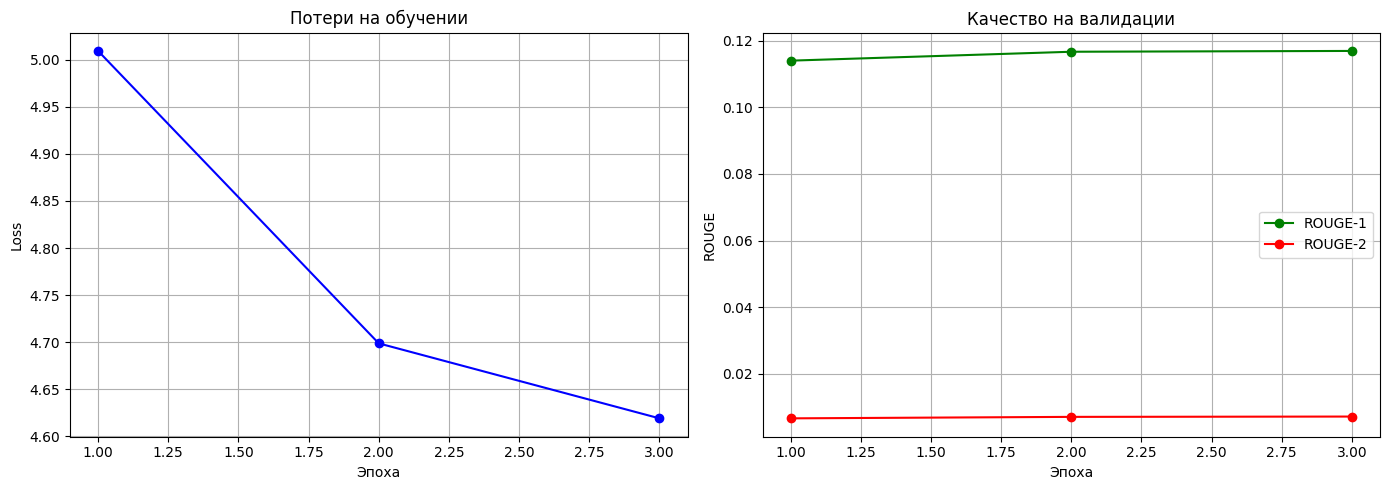


🔚 Финальные метрики:
   Loss: 4.6188
   ROUGE-1: 0.1170
   ROUGE-2: 0.0071


In [15]:
# %% [markdown]
# ## 4. Графики обучения

# %%
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Потери
plt.subplot(1, 2, 1)
plt.plot(history["epochs"], history["train_loss"], 'b-o')
plt.title("Потери на обучении")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)

# ROUGE
plt.subplot(1, 2, 2)
plt.plot(history["epochs"], history["val_rouge1"], 'g-o', label='ROUGE-1')
plt.plot(history["epochs"], history["val_rouge2"], 'r-o', label='ROUGE-2')
plt.title("Качество на валидации")
plt.xlabel("Эпоха")
plt.ylabel("ROUGE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n🔚 Финальные метрики:")
print(f"   Loss: {history['train_loss'][-1]:.4f}")
print(f"   ROUGE-1: {history['val_rouge1'][-1]:.4f}")
print(f"   ROUGE-2: {history['val_rouge2'][-1]:.4f}")

In [16]:
# %% [markdown]
# ## 5. Финальная оценка на тестовой выборке

# %%
from torch.utils.data import DataLoader
from src.next_token_dataset import NextTokenDataset
from src.eval_lstm import evaluate_model

df_test = pd.read_csv("data/test.csv", encoding="utf-8")
if DEBUG_MODE:
    df_test = df_test.iloc[:min(100, len(df_test))]

test_dataset = NextTokenDataset(
    texts=df_test["cleaned_text"].tolist(),
    vocab=vocab,
    seq_len=config["model"]["seq_len"]
)
test_loader = DataLoader(test_dataset, batch_size=config["training"]["batch_size"], shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_scores = evaluate_model(
    model=model,
    data_loader=test_loader,
    vocab=vocab,
    device=device,
    max_new_tokens=config["training"]["max_gen_tokens"],
    seq_len=config["model"]["seq_len"]
)

print(f"✅ Тестовые метрики:\n  ROUGE-1: {test_scores['rouge1']:.4f}\n  ROUGE-2: {test_scores['rouge2']:.4f}")

Оценка LSTM: 100%|██████████████████████████████████████████████████████████████████| 2192/2192 [10:27<00:00,  3.49it/s]


✅ Тестовые метрики:
  ROUGE-1: 0.1170
  ROUGE-2: 0.0071


In [17]:
# %% [markdown]
# ## 6. Инференс: генерация продолжения

# %%
def predict_completion(input_text: str, model, vocab, seq_len=10, max_new_tokens=8):
    import re
    clean_text = input_text.lower()
    clean_text = re.sub(r"http\S+|www\S+|https\S+", "", clean_text, flags=re.MULTILINE)
    clean_text = re.sub(r"@\w+", "", clean_text)
    clean_text = re.sub(r"[^a-zа-я\s]", " ", clean_text)
    clean_text = re.sub(r"\s+", " ", clean_text).strip()
    
    tokens = clean_text.split()
    if not tokens:
        return "(пустой ввод)"
    
    input_ids = [vocab.get(t, vocab["<unk>"]) for t in tokens]
    if len(input_ids) > seq_len:
        input_ids = input_ids[-seq_len:]
    
    pad_id = vocab["<pad>"]
    if len(input_ids) < seq_len:
        input_ids = [pad_id] * (seq_len - len(input_ids)) + input_ids
    
    input_tensor = torch.tensor([input_ids], dtype=torch.long)
    model.eval()
    with torch.no_grad():
        generated = model.generate(
            input_ids=input_tensor,
            max_new_tokens=max_new_tokens,
            temperature=0.9,
            top_k=50
        )
    
    inv_vocab = {v: k for k, v in vocab.items()}
    gen_ids = generated[0][seq_len:].tolist()
    gen_tokens = [inv_vocab.get(i, "<unk>") for i in gen_ids]
    return " ".join(gen_tokens)

# Примеры генерации
examples = ["hello friends", "i love you", "feeling sad today", "can't wait for", "let's travel"]
print("🔍 Примеры генерации:\n")
for ex in examples:
    completion = predict_completion(
        ex, model, vocab,
        seq_len=config["model"]["seq_len"],
        max_new_tokens=config["training"]["max_gen_tokens"]
    )
    print(f"Ввод: {ex}\n→ {completion}\n")

🔍 Примеры генерации:

Ввод: hello friends
→ <unk> i still have no internet for the day in

Ввод: i love you
→ <unk> <unk> <unk> <unk> <unk> p s what s your

Ввод: feeling sad today
→ though i mean i should have said my hair looks

Ввод: can't wait for
→ the next week i may be a long day so

Ввод: let's travel
→ on your new vid and send it to the <unk>



In [18]:
# %% [markdown]
# ## 7. Сравнение с DistilGPT2 (zero-shot)

# %%
try:
    from src.eval_transformer_pipeline import evaluate_distilgpt2
    
    num_samples = 50 if DEBUG_MODE else 200
    transformer_scores = evaluate_distilgpt2(
        test_csv_path="data/test.csv",
        seq_len=config["model"]["seq_len"],
        max_new_tokens=config["training"]["max_gen_tokens"],
        num_samples=num_samples,
        device=-1  # CPU
    )
    
    print("🤖 DistilGPT2 (без дообучения):")
    print(f"  ROUGE-1: {transformer_scores['rouge1']:.4f}")
    print(f"  ROUGE-2: {transformer_scores['rouge2']:.4f}")
    
    # Сравнительная таблица
    from IPython.display import display, HTML
    html = f"""
    <table border="1" class="dataframe">
      <thead><tr><th>Модель</th><th>ROUGE-1</th><th>ROUGE-2</th></tr></thead>
      <tbody>
        <tr><td><b>Твоя LSTM</b></td><td>{test_scores['rouge1']:.4f}</td><td>{test_scores['rouge2']:.4f}</td></tr>
        <tr><td><b>DistilGPT2</b></td><td>{transformer_scores['rouge1']:.4f}</td><td>{transformer_scores['rouge2']:.4f}</td></tr>
      </tbody>
    </table>
    """
    display(HTML(html))
    
except Exception as e:
    print("⚠️ DistilGPT2 недоступен:", e)
    print("Убедитесь, что установлены: transformers, rouge_score")

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu
Оценка DistilGPT2:   0%|                                                           | 5/159069 [00:00<1:47:50, 24.58it/s]The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Оценка DistilGPT2:   0%|                                                          | 17/159069 [00:01<2:32:52, 17.34it/s]The following generation flags are not valid and may be ignored: ['temperature']. 

🤖 DistilGPT2 (без дообучения):
  ROUGE-1: 0.0719
  ROUGE-2: 0.0066


Модель,ROUGE-1,ROUGE-2
Твоя LSTM,0.1170,0.0071
DistilGPT2,0.0719,0.0066


In [19]:
# %% [markdown]
# ## 🤖 Инференс DistilGPT2 (вручную)

# %%
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import re

# === Настройки (должны совпадать с LSTM для честного сравнения) ===
SEQ_LEN = 8          # ← возьми из config["model"]["seq_len"]
MAX_NEW_TOKENS = 6   # ← из config["training"]["max_gen_tokens"]
# =================================================================

print("Загрузка DistilGPT2 (может занять 10–30 секунд)...")
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name)
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=-1  # CPU; поставь 0 для GPU
)

def clean_text(text: str) -> str:
    """Та же очистка, что и в data_utils.py"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-zа-я\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def predict_gpt2_completion(input_text: str, seq_len=SEQ_LEN, max_new_tokens=MAX_NEW_TOKENS):
    # Очистка
    clean_prompt = clean_text(input_text)
    words = clean_prompt.split()
    
    if not words:
        return "(пустой ввод)"
    
    # Берём последние seq_len слов как контекст
    if len(words) > seq_len:
        words = words[-seq_len:]
    prompt = " ".join(words)
    
    # Генерация
    try:
        result = generator(
            prompt,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # greedy decoding, как в LSTM
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            return_full_text=False
        )
        return result[0]["generated_text"].strip()
    except Exception as e:
        return f"(ошибка: {e})"

# === Примеры или ручной ввод ===
examples = [
    "hello friends",
    "i love you",
    "feeling sad today",
    "can't wait for"
]

print("🔍 Примеры генерации DistilGPT2:\n")
for ex in examples:
    completion = predict_gpt2_completion(ex)
    print(f"Ввод: {ex}\n→ {completion}\n")

# Можно добавить и свой ввод:
# my_input = "the weather is"
# print(f"Мой ввод: {my_input}\n→ {predict_gpt2_completion(my_input)}")

Загрузка DistilGPT2 (может занять 10–30 секунд)...


Device set to use cpu
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔍 Примеры генерации DistilGPT2:

Ввод: hello friends
→ , and I’m



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Ввод: i love you
→ .

Ввод: feeling sad today
→ .”

Ввод: can't wait for
→ the next round of the season

